**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/AVI.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date   Open   High    Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01  223.2  223.2  223.2  223.2       0                  0.0   
1 1999-01-04  223.2  225.0  225.0  225.0  271100                  0.0   
2 1999-01-05  225.0  240.0  240.0  240.0  199000                  0.0   
3 1999-01-06  240.0  270.0  270.0  270.0  218100                  0.0   
4 1999-01-07  270.0  270.0  270.0  270.0  246418                  0.0   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  0.0              0.0      -           -   
1                  0.0              0.0      -           -   
2                  0.0              0.0      -           -   
3                  0.0              0.0      -           -   
4                  0.0              0.0      -           -   

   Total Return Index (TRI)  
0                      52.0  
1                      52.0  
2                      56.0  
3                      63.0  
4                      63.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.007605  0.000000  0.010663 -0.022473  0.000000  0.000000   
2000-05-12 -0.046520  0.000000  0.000000  0.010663 -0.022473  0.000000   
2000-05-15 -0.048034  0.001514  0.001514  0.001514  0.012177 -0.020959   
2000-05-16 -0.080295 -0.020959  0.000000  0.001514  0.001514  0.012177   
2000-05-17 -0.094559  0.018210  0.006033  0.006033  0.007547  0.007547   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11  0.008166  0.005831  0.013466   0.011441  ...     -0.012177   
2000-05-12  0.005113  0.003887  0.011916   0.009361  ...      0.000000   
2000-05-15  0.002362  0.003096  0.010517   0.007934  ...      0.000000   
2000-05-16 -0.006324 -0.004922  0.005344   0.002681  ...      0.001514   
2000-05-17 -0.000247  0.002789  0.005486   0.005504  ...     -0.020959   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11     0.000000      0.000000          -0.001514          0.000000   
2000-05-12     0.000000      0.000000           0.000000          0.000000   
2000-05-15     0.001514      0.001514           0.001514          0.001514   
2000-05-16    -0.020959     -0.020959           0.001514         -0.020959   
2000-05-17     0.018210      0.018210          -0.014926          0.018210   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.000000           -0.001514           0.000000   
2000-05-12            0.000000            0.000000           0.000000   
2000-05-15            0.001514            0.001514           0.001514   
2000-05-16           -0.020959            0.001514          -0.020959   
2000-05-17            0.018210           -0.014926           0.018210   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11            0.000000         -0.010663  
2000-05-12            0.000000          0.000000  
2000-05-15            0.001514          0.000000  
2000-05-16           -0.020959         -0.020959  
2000-05-17            0.018210          0.012177  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.008894478509110572
  dropout = 0.2153831800963054
  units = 248
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 14
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0010513484884060805
RMSE = 0.03242450444349274
MAE = 0.023291137819064254
R-Squared = 0.00786461391395099

Results on Validation set: 
MSE = 0.0010950147926770775
RMSE = 0.03309100773136227
MAE = 0.024557871456824018
R-Squared = -0.05787536275835259

Results on Testing set: 
MSE = 0.0005284282811163092
RMSE = 0.022987567968715376
MAE = 0.017743663257234015
R-Squared = -0.007282047842743999



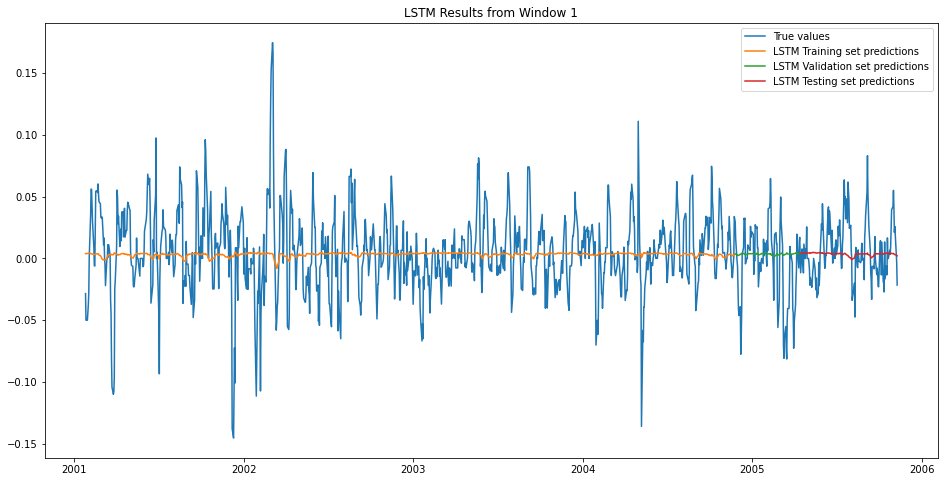

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0009841740008500117
RMSE = 0.03137154763236923
MAE = 0.02261668230707956
R-Squared = 0.01092116356459194

Results on Validation set: 
MSE = 0.0005701739252869634
RMSE = 0.023878314959120614
MAE = 0.018747201016880388
R-Squared = 0.029940888566175494

Results on Testing set: 
MSE = 0.0014093900669889573
RMSE = 0.03754184421400948
MAE = 0.027880132469275985
R-Squared = -0.091386489360481



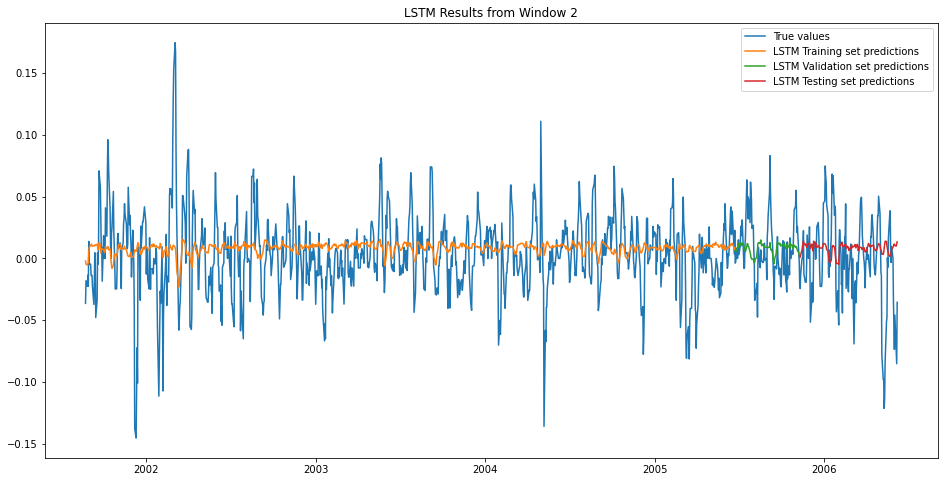

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0007711422991326151
RMSE = 0.027769449024649645
MAE = 0.020757053460497835
R-Squared = -0.01722103036168665

Results on Validation set: 
MSE = 0.0013941237824673558
RMSE = 0.03733796703715075
MAE = 0.027246889118191002
R-Squared = 0.04344857243895328

Results on Testing set: 
MSE = 0.001322415176162237
RMSE = 0.036365026827464834
MAE = 0.02738472556098183
R-Squared = -0.1157112055389573



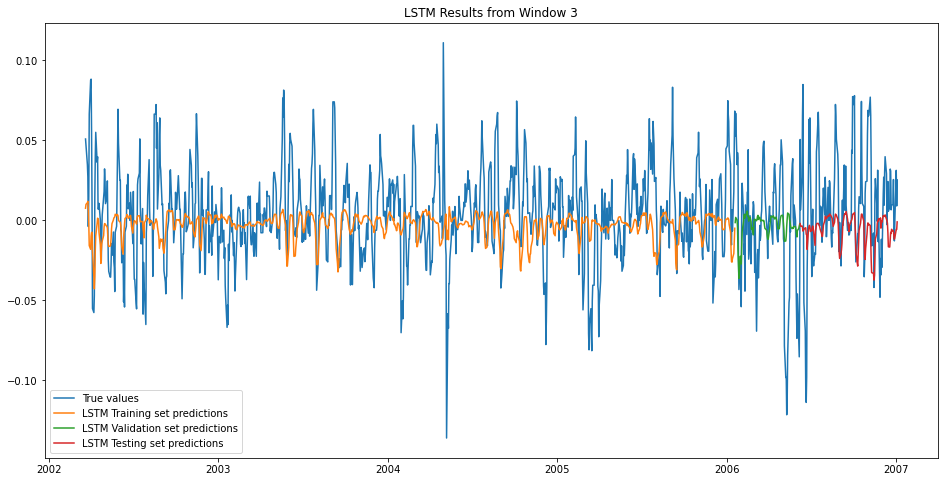

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0006236926181620516
RMSE = 0.024973838674942458
MAE = 0.017929861476216856
R-Squared = 0.26651525828060785

Results on Validation set: 
MSE = 0.0005578096462562391
RMSE = 0.023617994120082236
MAE = 0.019396909256746222
R-Squared = 0.353647585031423

Results on Testing set: 
MSE = 0.0013443565452034803
RMSE = 0.03666546802106146
MAE = 0.028012370080944978
R-Squared = -0.13616495476673718



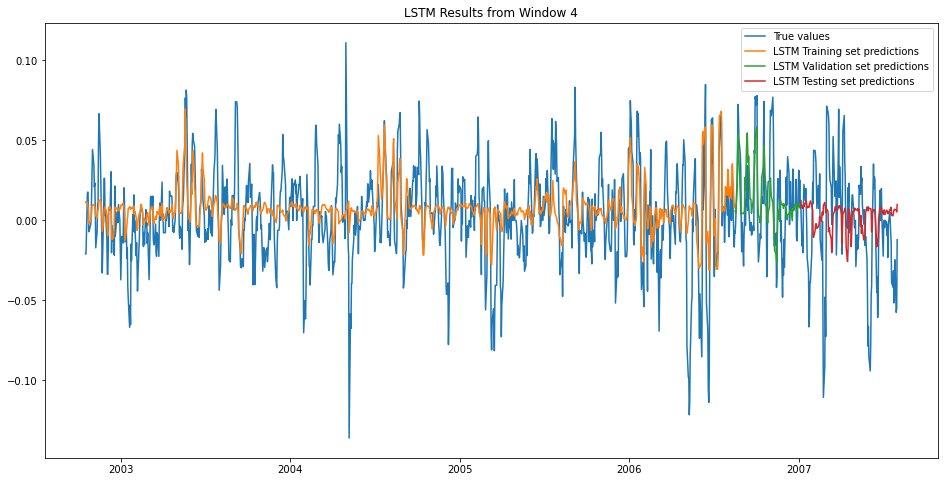

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0010249755337638357
RMSE = 0.032015239086469985
MAE = 0.02308752565152878
R-Squared = -0.0701428414549976

Results on Validation set: 
MSE = 0.0010188863295623974
RMSE = 0.031919998896654075
MAE = 0.02373592070531825
R-Squared = -0.02089870022782936

Results on Testing set: 
MSE = 0.001928489049877874
RMSE = 0.04391456534998239
MAE = 0.035222071607347624
R-Squared = -0.12895202267174644



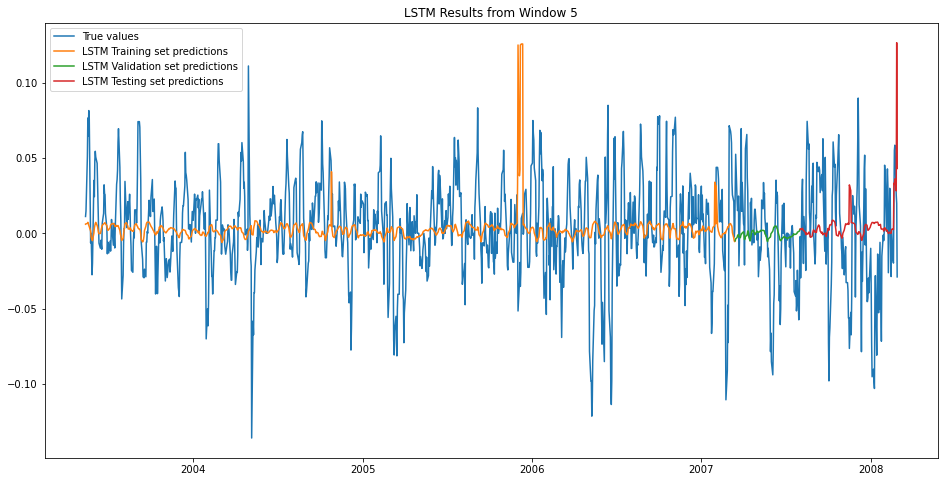

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0010333618078592149
RMSE = 0.03214594543421013
MAE = 0.023934178477706364
R-Squared = -0.007649688648200259

Results on Validation set: 
MSE = 0.0017629773658782116
RMSE = 0.041987824019329836
MAE = 0.03468174918437801
R-Squared = -0.0023780183098833785

Results on Testing set: 
MSE = 0.0023447259425321398
RMSE = 0.0484223702696609
MAE = 0.03983529060191464
R-Squared = -0.007101911787889215



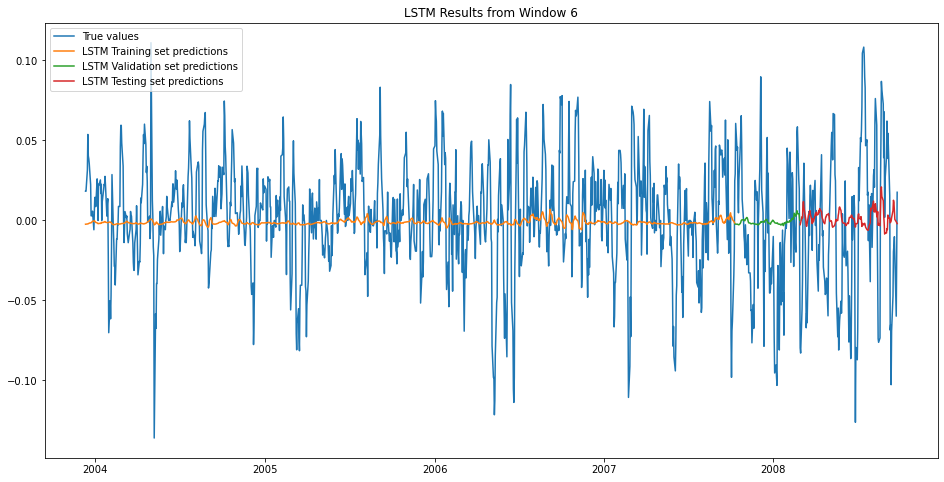

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0009810606414021508
RMSE = 0.031321887577254195
MAE = 0.02360010022224737
R-Squared = 0.15267954276773854

Results on Validation set: 
MSE = 0.003140031217962429
RMSE = 0.0560359814580099
MAE = 0.04509720964716724
R-Squared = -0.08088921596128706

Results on Testing set: 
MSE = 0.007463643846610516
RMSE = 0.08639238303583549
MAE = 0.057052845204092935
R-Squared = 0.048439612765379



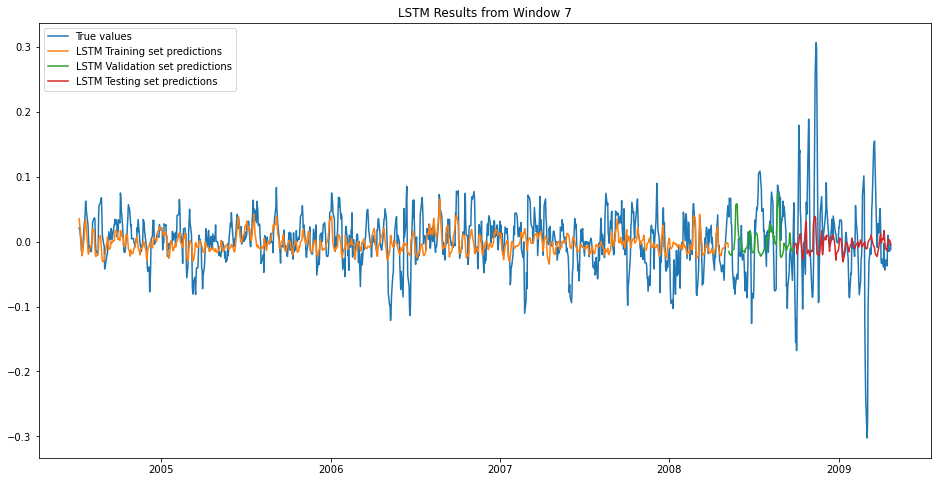

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0019874354046751984
RMSE = 0.04458066177924234
MAE = 0.03163594659439642
R-Squared = 0.015437214592316839

Results on Validation set: 
MSE = 0.00492350760345852
RMSE = 0.07016771054736302
MAE = 0.043430816357668114
R-Squared = 0.002317395643298581

Results on Testing set: 
MSE = 0.0010890008782883627
RMSE = 0.033000013307396756
MAE = 0.02719107060989928
R-Squared = -0.11317509521795377



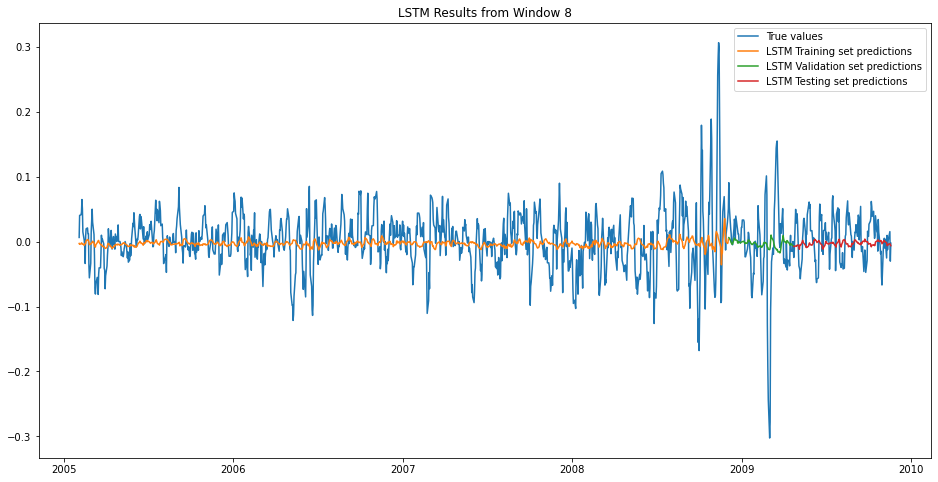

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0024820669522457274
RMSE = 0.049820346769625434
MAE = 0.03465466494321191
R-Squared = -0.01210236297082301

Results on Validation set: 
MSE = 0.0008548546742015851
RMSE = 0.029237897910102655
MAE = 0.023223187265508267
R-Squared = -0.0029077719382568645

Results on Testing set: 
MSE = 0.0008286135056034523
RMSE = 0.028785647562690895
MAE = 0.02204000100880153
R-Squared = -0.046589285779471856



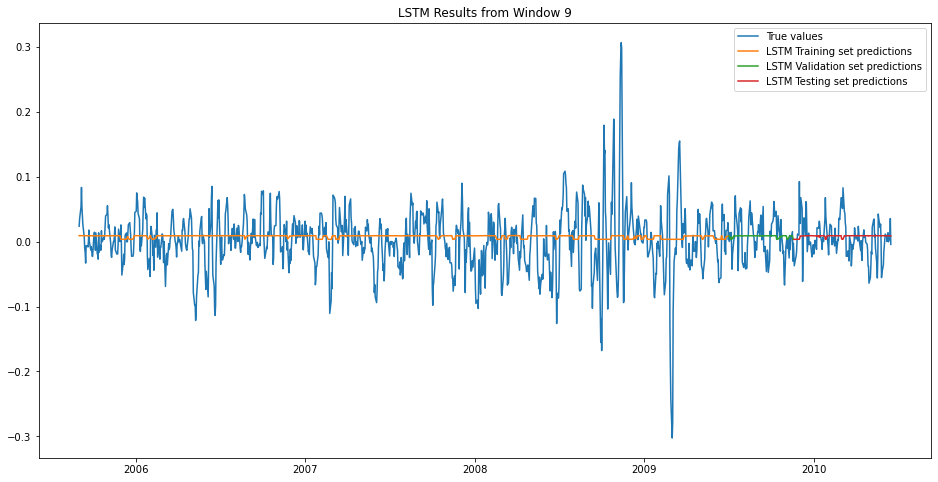

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0021078645046671935
RMSE = 0.04591148554193377
MAE = 0.031352595189946576
R-Squared = 0.14462844573937061

Results on Validation set: 
MSE = 0.0007063458199090901
RMSE = 0.026577167266454302
MAE = 0.019511882079443037
R-Squared = 0.05916425454225671

Results on Testing set: 
MSE = 0.0005603025052094521
RMSE = 0.023670709858587935
MAE = 0.019071682286965395
R-Squared = -0.15793551840039388



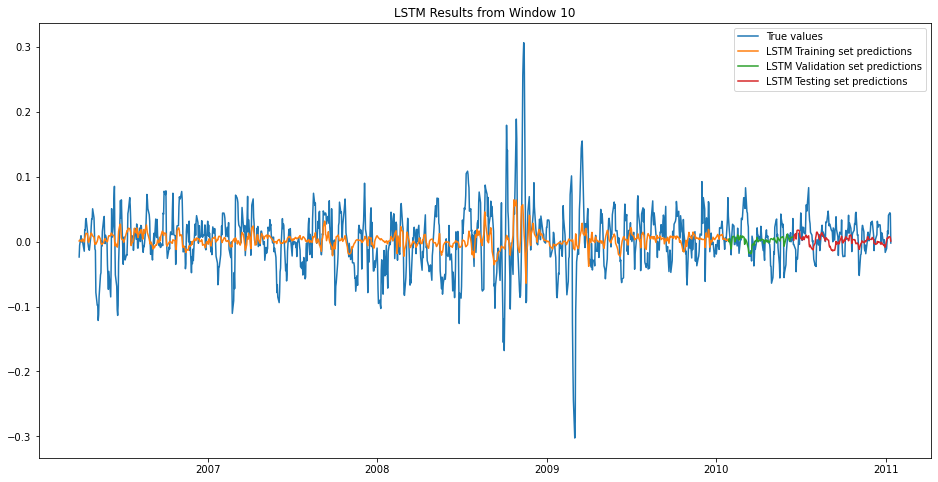

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0021479389525556167
RMSE = 0.046345862302428
MAE = 0.032046574250782695
R-Squared = 0.07634051064007463

Results on Validation set: 
MSE = 0.0003584954677717589
RMSE = 0.018933976544079665
MAE = 0.0149815479267971
R-Squared = 0.046149557434685184

Results on Testing set: 
MSE = 0.0007621320576299013
RMSE = 0.027606739351649288
MAE = 0.021448279824123066
R-Squared = -0.20186089766202575



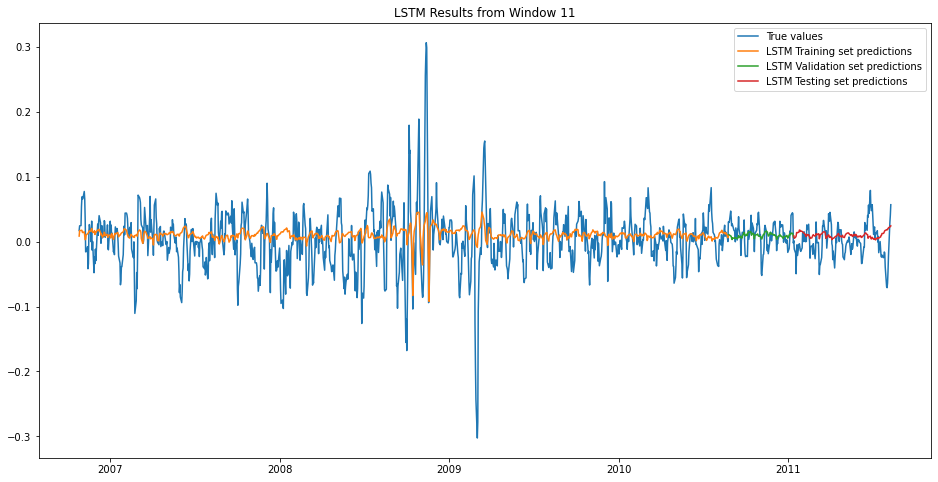

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0024052711151165227
RMSE = 0.049043563442275714
MAE = 0.03364300521000776
R-Squared = -0.07569964196011969

Results on Validation set: 
MSE = 0.0007457101397620112
RMSE = 0.02730769378329139
MAE = 0.02040939823691051
R-Squared = 0.013885714402596672

Results on Testing set: 
MSE = 0.0010540016471353596
RMSE = 0.03246539152906306
MAE = 0.026755987550272878
R-Squared = -0.7468337677133312



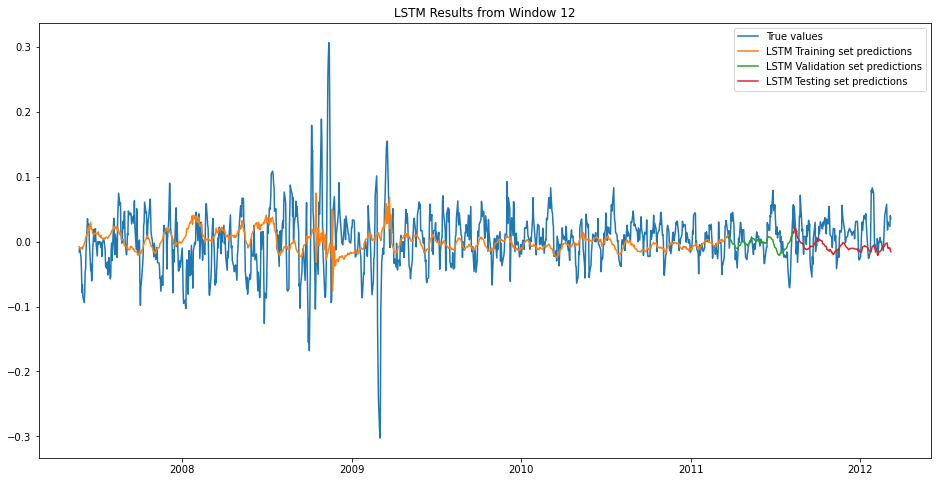

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.002114753922656075
RMSE = 0.0459864536864507
MAE = 0.03048123211819629
R-Squared = 0.00040007951386134

Results on Validation set: 
MSE = 0.0005991664293793533
RMSE = 0.024477876324946028
MAE = 0.01899741610310138
R-Squared = -0.008255345285868687

Results on Testing set: 
MSE = 0.0007893928168384609
RMSE = 0.028096135265165224
MAE = 0.02056700272713676
R-Squared = -0.002926934149633187



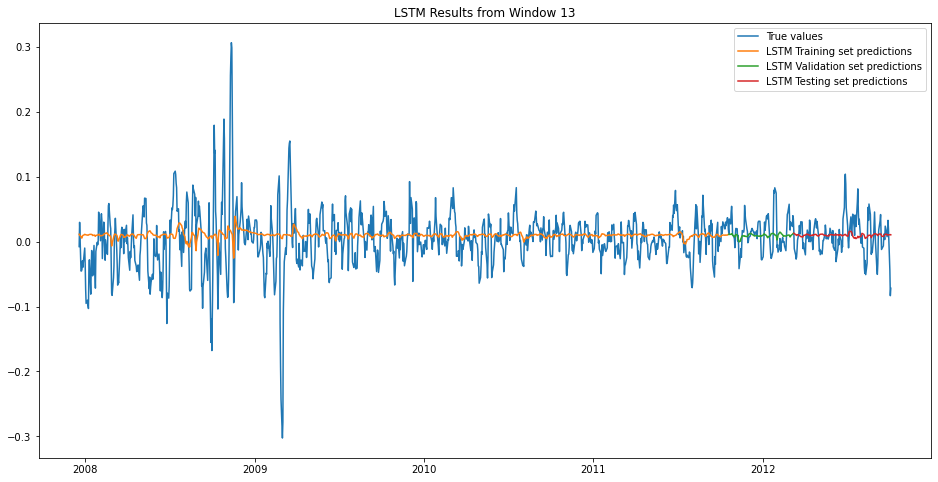

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0016701198009136944
RMSE = 0.04086709924760619
MAE = 0.02592562852639721
R-Squared = 0.09626025381047876

Results on Validation set: 
MSE = 0.0009998383870455608
RMSE = 0.031620221173254956
MAE = 0.02295673067809486
R-Squared = 0.025527489395589242

Results on Testing set: 
MSE = 0.0010455612996492134
RMSE = 0.03233514032208942
MAE = 0.024216397932069384
R-Squared = -0.39709633280689705



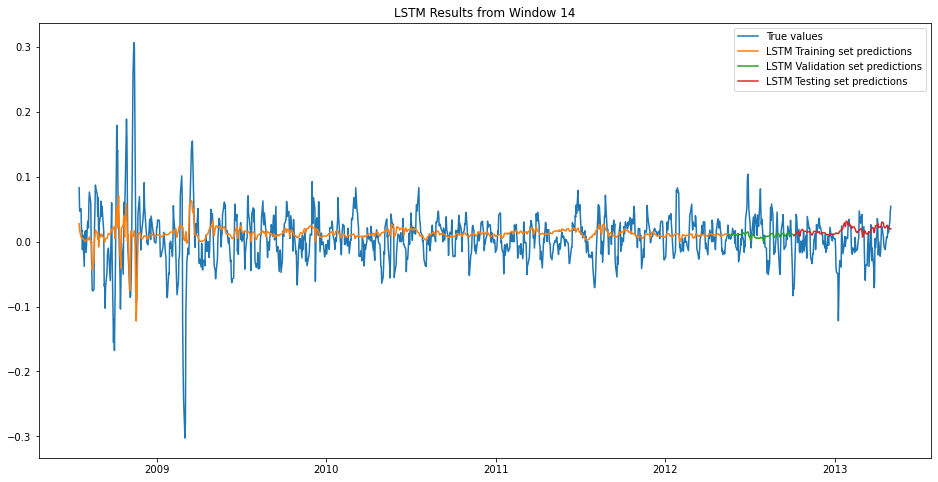

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0011755484853509396
RMSE = 0.03428627254967999
MAE = 0.023532160707731755
R-Squared = -0.02720591672409922

Results on Validation set: 
MSE = 0.0008348834506680239
RMSE = 0.028894349805247806
MAE = 0.02099635703426967
R-Squared = -0.01152620578764263

Results on Testing set: 
MSE = 0.0009161061856998881
RMSE = 0.030267246087146548
MAE = 0.023571655156568786
R-Squared = -0.0021039469272376987



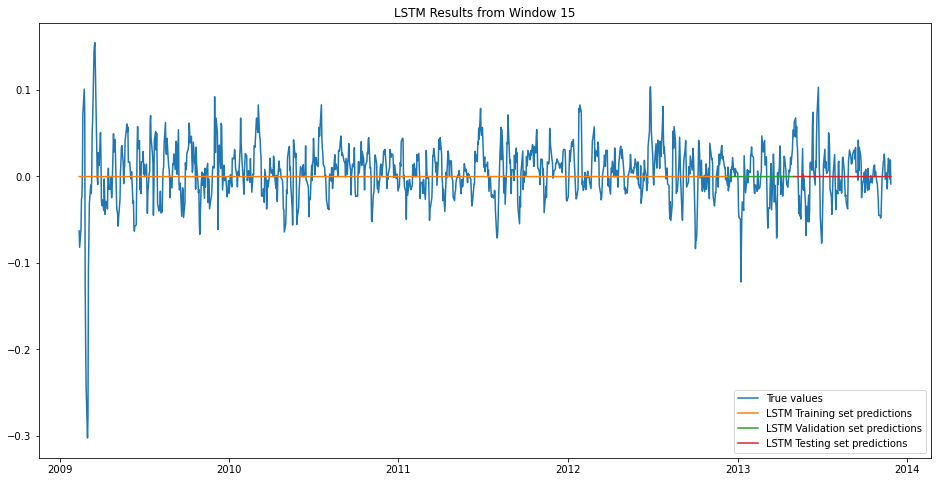

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007912356151214605
RMSE = 0.028128910663611922
MAE = 0.021361417453147066
R-Squared = -0.038391380432514666

Results on Validation set: 
MSE = 0.0004464235607402737
RMSE = 0.021128737793353242
MAE = 0.016726896201320323
R-Squared = 0.024617713065621105

Results on Testing set: 
MSE = 0.0005558601622072102
RMSE = 0.02357668683694149
MAE = 0.018416479661100525
R-Squared = -0.07919906910941554



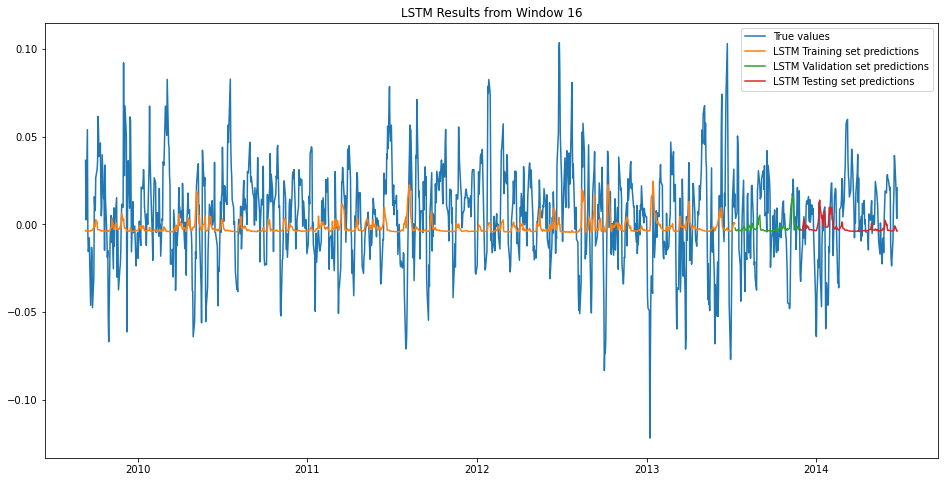

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007317096036674083
RMSE = 0.02705013130591806
MAE = 0.020228748362188305
R-Squared = -0.0016425728091487013

Results on Validation set: 
MSE = 0.0003602582093525075
RMSE = 0.018980469155226578
MAE = 0.015136961693985934
R-Squared = -0.019932918852477055

Results on Testing set: 
MSE = 0.0006902183140701502
RMSE = 0.026272006281784995
MAE = 0.020334126990959423
R-Squared = 0.022560887277919828



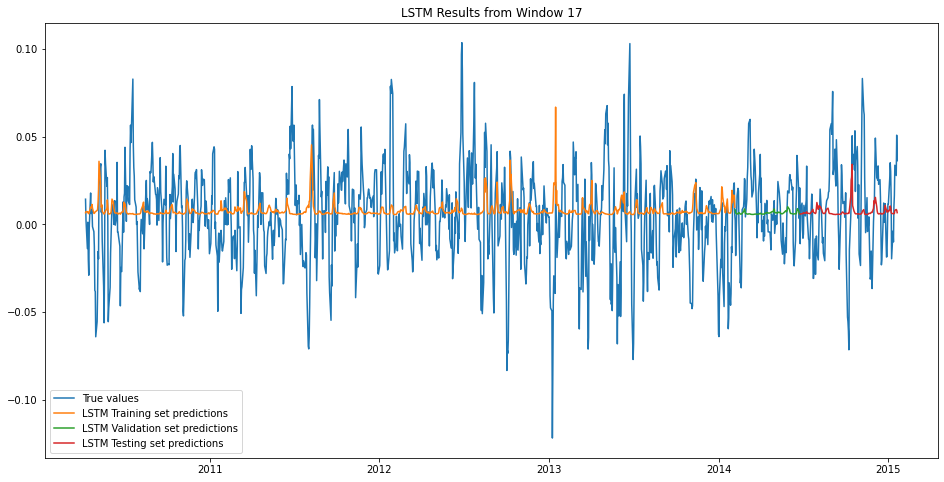

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0007106986978301926
RMSE = 0.026658932796160325
MAE = 0.020031996950041788
R-Squared = -0.019593417163023652

Results on Validation set: 
MSE = 0.0007799987295714193
RMSE = 0.027928457343208545
MAE = 0.02176501363411658
R-Squared = 0.037503237365342335

Results on Testing set: 
MSE = 0.0009367283229838599
RMSE = 0.030606017757687128
MAE = 0.026062336390255177
R-Squared = -0.31162494803227925



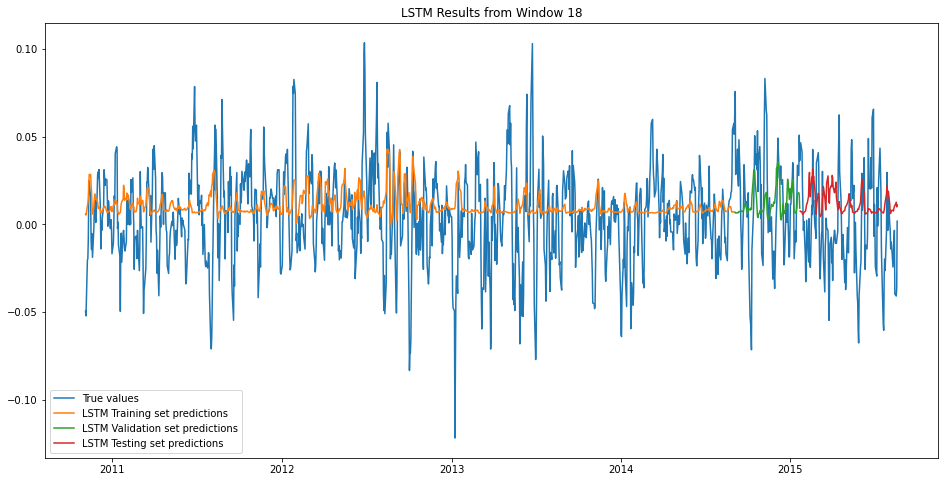

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007598862999312042
RMSE = 0.02756603525955817
MAE = 0.021194428826831455
R-Squared = -0.0066125820642812805

Results on Validation set: 
MSE = 0.0007861693872482902
RMSE = 0.028038712296542617
MAE = 0.022902898809600787
R-Squared = 0.0009676052186367023

Results on Testing set: 
MSE = 0.0011006306491196426
RMSE = 0.033175753934457056
MAE = 0.027819373151039516
R-Squared = 0.01976431782186605



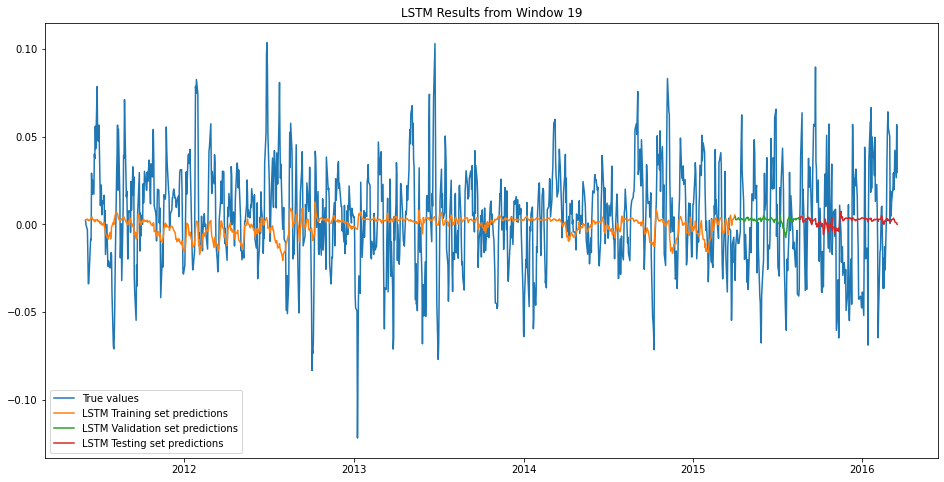

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0008114079627686439
RMSE = 0.028485223586425364
MAE = 0.021968300924551848
R-Squared = -0.05062379990830035

Results on Validation set: 
MSE = 0.0011726583016017156
RMSE = 0.03424409878507121
MAE = 0.029080941116714026
R-Squared = -2.0342078765667182e-05

Results on Testing set: 
MSE = 0.000683239827494229
RMSE = 0.026138856660042134
MAE = 0.021098741189312868
R-Squared = -0.03905702138800726



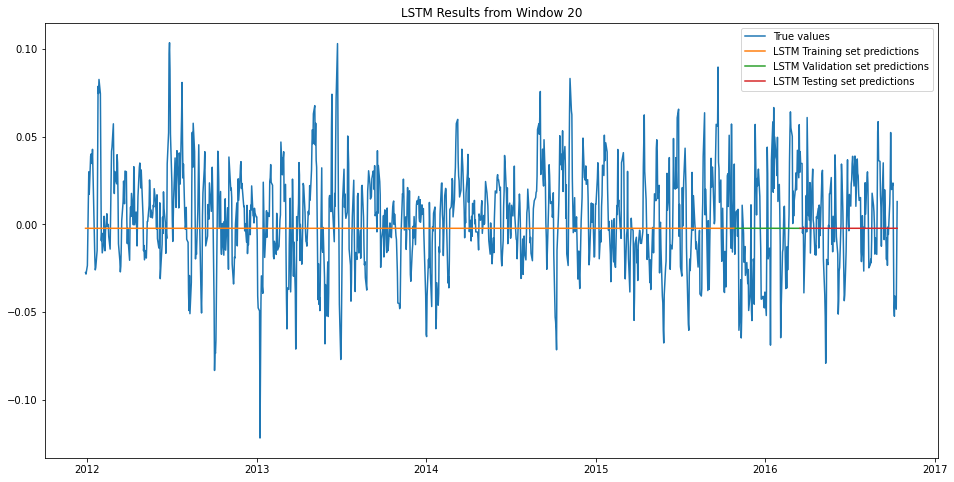

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0008175872340089783
RMSE = 0.028593482369396322
MAE = 0.02239419016452769
R-Squared = -0.014279606171565984

Results on Validation set: 
MSE = 0.0005821675303059381
RMSE = 0.024128148091097628
MAE = 0.02009072017928408
R-Squared = 0.08429140150952596

Results on Testing set: 
MSE = 0.0006235922621755214
RMSE = 0.024971829371824593
MAE = 0.01873790386597637
R-Squared = -0.15226120535310916



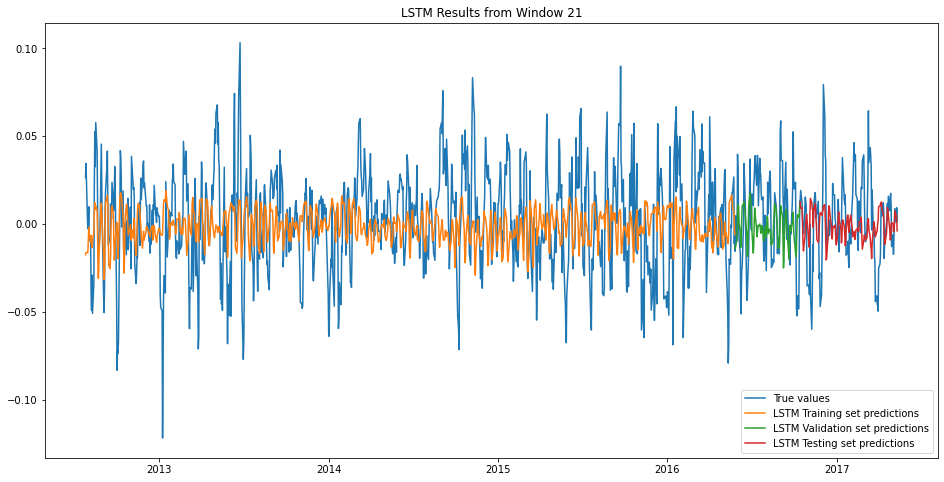

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0007835114124360445
RMSE = 0.027991273862331533
MAE = 0.022026327404102274
R-Squared = 0.0009846653741510947

Results on Validation set: 
MSE = 0.0004406106247820748
RMSE = 0.020990727114182463
MAE = 0.016199218842221284
R-Squared = 0.01060007946947028

Results on Testing set: 
MSE = 0.0004114608085937723
RMSE = 0.020284496754757617
MAE = 0.01593021727352286
R-Squared = -0.002305141100211072



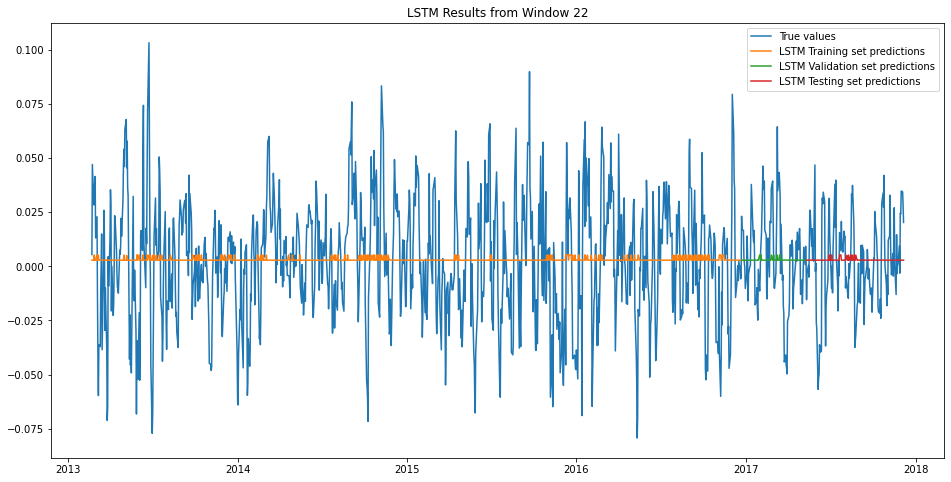

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0006505523518040821
RMSE = 0.02550592777775555
MAE = 0.01970623826947691
R-Squared = 0.07151173707296155

Results on Validation set: 
MSE = 0.0002096477804172247
RMSE = 0.014479218915992144
MAE = 0.011419692876191241
R-Squared = 0.27609174657757796

Results on Testing set: 
MSE = 0.0013350061504623116
RMSE = 0.03653773597887958
MAE = 0.027265317158806285
R-Squared = -0.14199048822215965



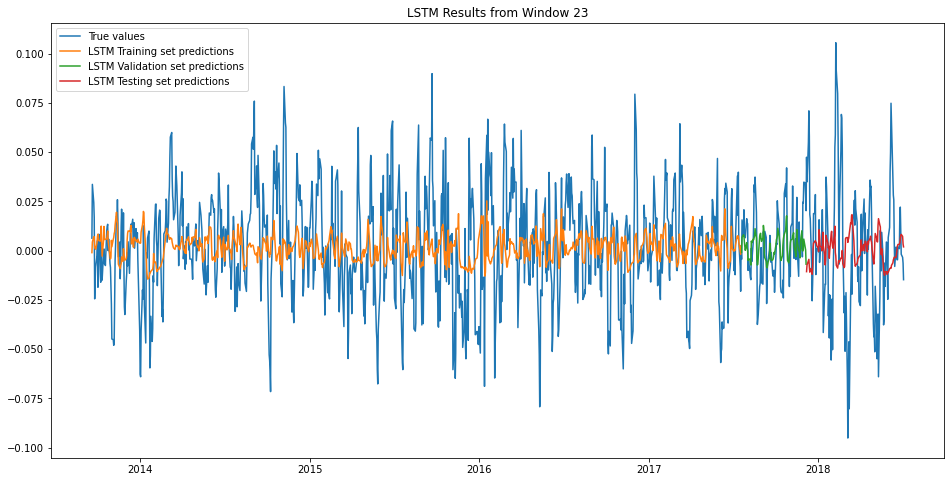

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.000712381428573873
RMSE = 0.026690474491358765
MAE = 0.02037209423648744
R-Squared = 0.0048598915465670744

Results on Validation set: 
MSE = 0.0010516304408963572
RMSE = 0.03242885198239921
MAE = 0.023985637097546718
R-Squared = -0.03505158296592503

Results on Testing set: 
MSE = 0.0015638514121315344
RMSE = 0.039545561219074064
MAE = 0.0277515840627014
R-Squared = -0.08039247687063078



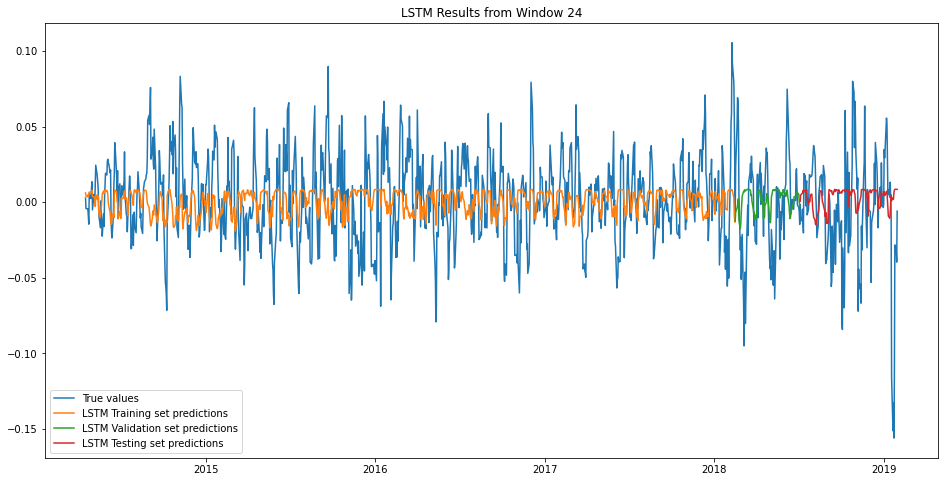

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4933

Results on Training set: 
MSE = 0.0006236548884028778
RMSE = 0.02497308327785894
MAE = 0.019170436483716847
R-Squared = 0.15876565985783608

Results on Validation set: 
MSE = 0.00197713755309937
RMSE = 0.04446501493420833
MAE = 0.030706186142741645
R-Squared = -0.03179917932078524

Results on Testing set: 
MSE = 0.0009872967110366364
RMSE = 0.031421277998143815
MAE = 0.0243813510445306
R-Squared = -0.04623665813550448



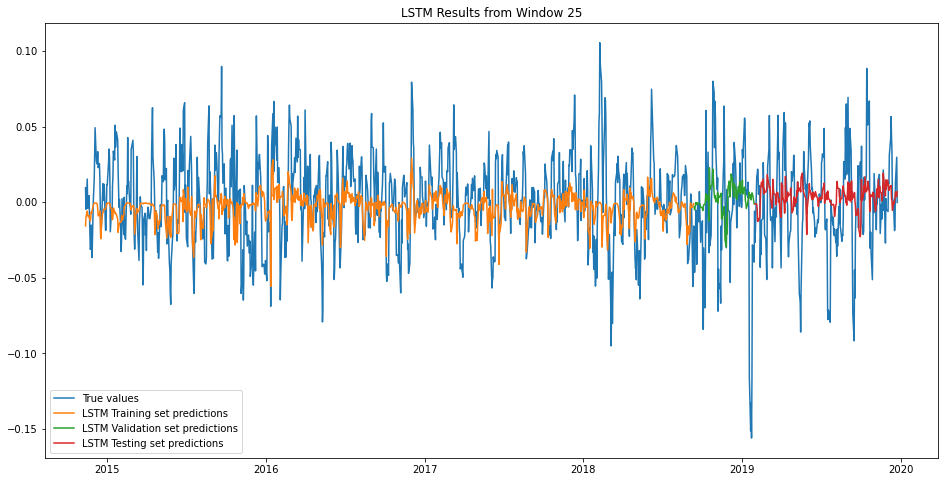

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 185
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.002576050711952346
  dropout = 0.18008333534734158
  units = 217

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 33
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0010127335774946398
RMSE = 0.03182347525797018
MAE = 0.022771064159668435
R-Squared = 0.04112807919145012

Results on Validation set: 
MSE = 0.001098786497304549
RMSE = 0.033147948613821476
MAE = 0.02476635939989471
R-Squared = -0.07731774191394547

Results on Testing set: 
MSE = 0.0005564988867235773
RMSE = 0.02359022862804804
MAE = 0.018406669627398717
R-Squared = -0.047335359325676896



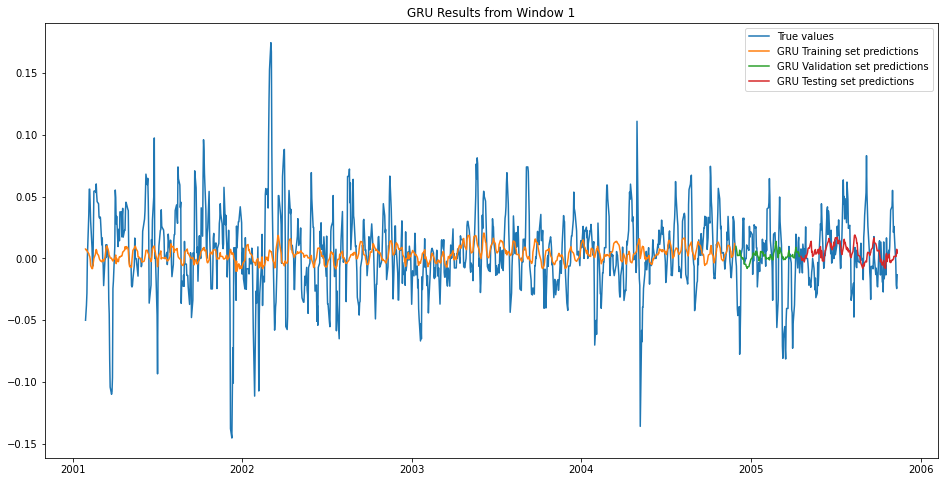

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0010245556936387698
RMSE = 0.032008681535464246
MAE = 0.02330533735191291
R-Squared = -0.03168232059338938

Results on Validation set: 
MSE = 0.0005845096819322116
RMSE = 0.024176635041548104
MAE = 0.018251490852979915
R-Squared = 0.02673169413388876

Results on Testing set: 
MSE = 0.001375119286933446
RMSE = 0.037082600865277045
MAE = 0.02760653041332733
R-Squared = -0.05197200188981732



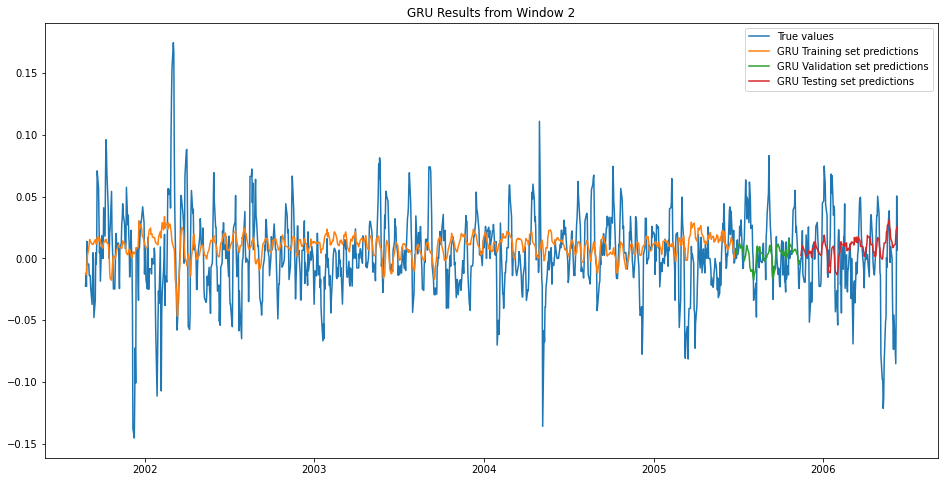

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0007564948338194437
RMSE = 0.02750445116375609
MAE = 0.020894605720949564
R-Squared = 0.0051317165489056515

Results on Validation set: 
MSE = 0.001445677857986915
RMSE = 0.03802207066937458
MAE = 0.02784673762608566
R-Squared = -0.03249500405730399

Results on Testing set: 
MSE = 0.0010394272265199349
RMSE = 0.03224014929431833
MAE = 0.02461249330374655
R-Squared = 0.11505683032074887



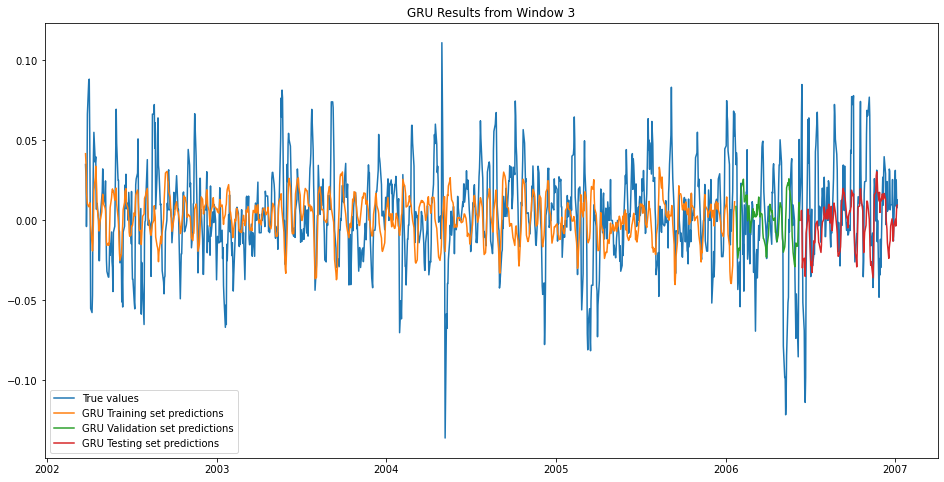

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 9.749109223042134e-05
RMSE = 0.009873757756316555
MAE = 0.006940734748727206
R-Squared = 0.8852127105533376

Results on Validation set: 
MSE = 0.0005564918939382316
RMSE = 0.023590080413984003
MAE = 0.019003361372912177
R-Squared = 0.3500963117767395

Results on Testing set: 
MSE = 0.0016224142687084379
RMSE = 0.04027920392346947
MAE = 0.03248545098774199
R-Squared = -0.368684657685002



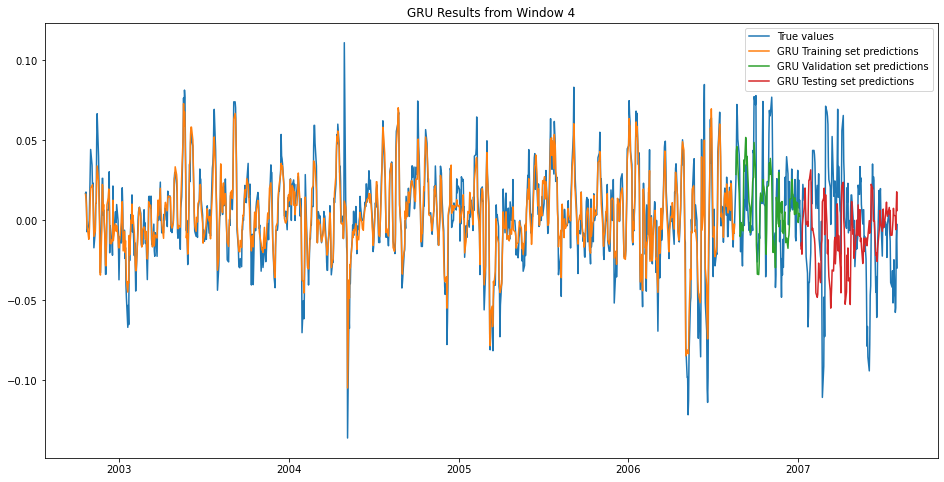

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0008371060117038647
RMSE = 0.02893278437523538
MAE = 0.021551399430914022
R-Squared = 0.12835561147746422

Results on Validation set: 
MSE = 0.0010069532118089364
RMSE = 0.031732526086161755
MAE = 0.023724362268949854
R-Squared = -0.04638063582491947

Results on Testing set: 
MSE = 0.0020381810994338193
RMSE = 0.04514621910452546
MAE = 0.03618807478846985
R-Squared = -0.14027806234545337



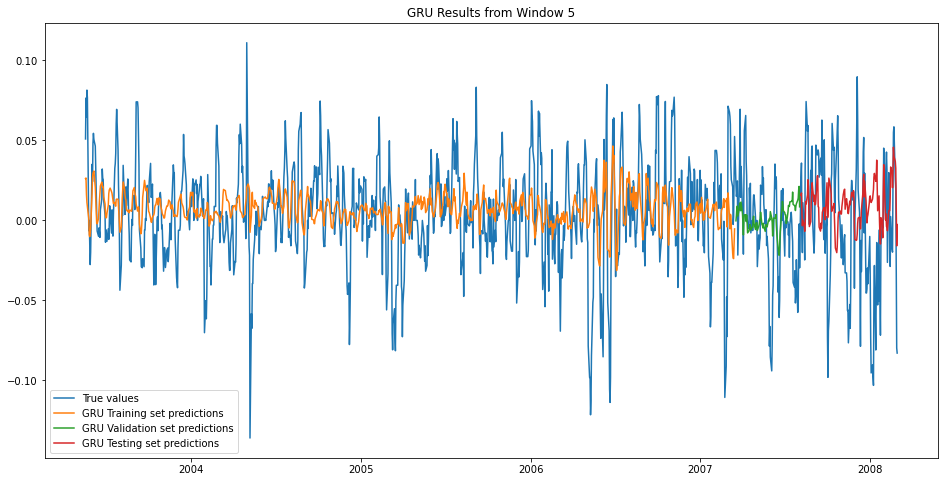

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0008887554612285744
RMSE = 0.029812001966130593
MAE = 0.02189835208948794
R-Squared = 0.13628074068085216

Results on Validation set: 
MSE = 0.001905102977466607
RMSE = 0.04364748535100971
MAE = 0.03543998594820183
R-Squared = -0.057445824056282735

Results on Testing set: 
MSE = 0.0025893394606020235
RMSE = 0.050885552572434774
MAE = 0.04087055843112212
R-Squared = -0.13662238358192735



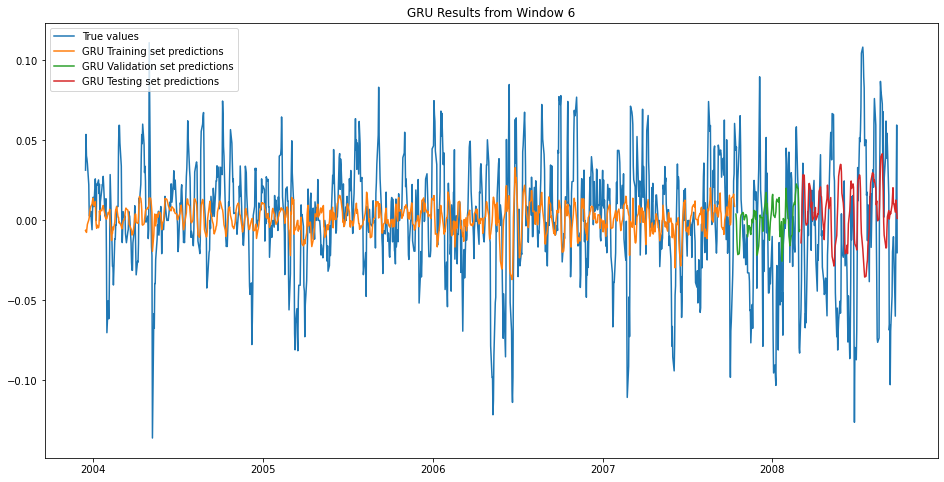

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0004889486575858304
RMSE = 0.022112183464909802
MAE = 0.01597795982154564
R-Squared = 0.5794478298884516

Results on Validation set: 
MSE = 0.002825307016879604
RMSE = 0.05315361715706283
MAE = 0.04205347085698616
R-Squared = 0.02021870556540495

Results on Testing set: 
MSE = 0.007646498794100444
RMSE = 0.08744426107012652
MAE = 0.06228649279673261
R-Squared = 0.023016279255000827



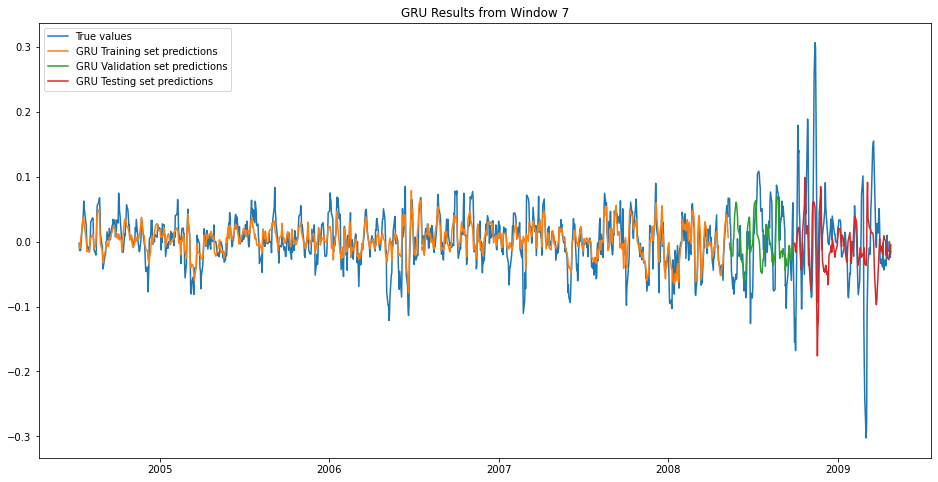

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0014754061130824328
RMSE = 0.03841101551745844
MAE = 0.02702311469783909
R-Squared = 0.27237496861130406

Results on Validation set: 
MSE = 0.004747568194887783
RMSE = 0.0689025993333182
MAE = 0.04271805333942025
R-Squared = 0.011327142169263227

Results on Testing set: 
MSE = 0.0014953191482647635
RMSE = 0.03866935670870106
MAE = 0.03200869042237335
R-Squared = -0.5188300367249663



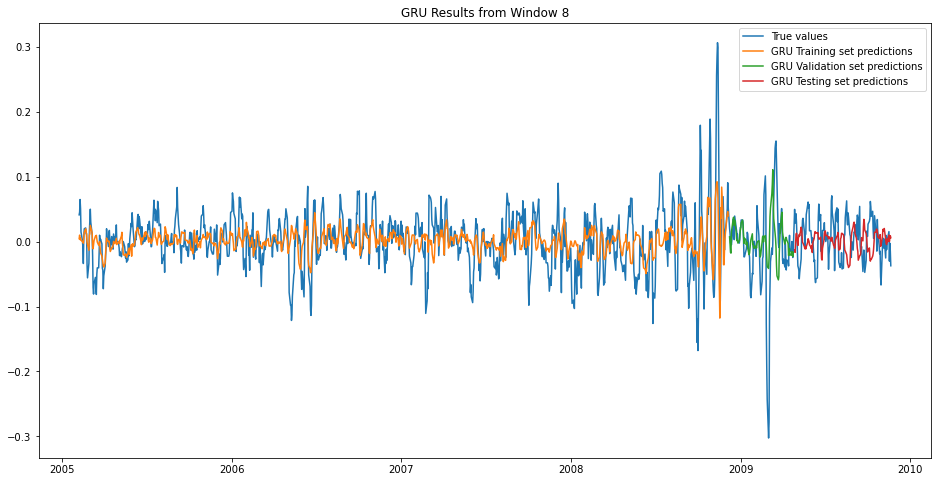

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.002304883203384203
RMSE = 0.048009199153747635
MAE = 0.033235018104238
R-Squared = 0.059571399981204864

Results on Validation set: 
MSE = 0.0009122894793860663
RMSE = 0.030204130170989302
MAE = 0.024183822035594583
R-Squared = -0.0439824714116519

Results on Testing set: 
MSE = 0.0007249288836753273
RMSE = 0.0269245034062901
MAE = 0.02003540039507922
R-Squared = 0.06867216458180925



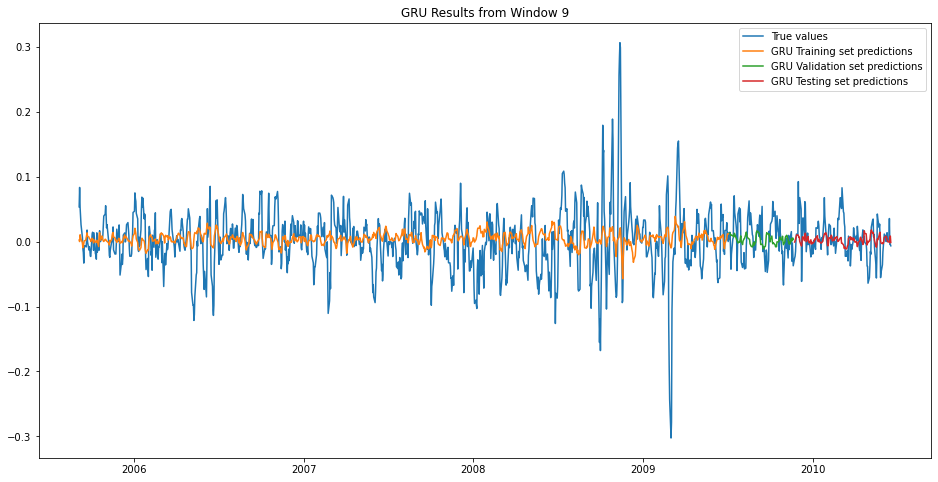

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0021391619221035273
RMSE = 0.04625107482106256
MAE = 0.03196001534745451
R-Squared = 0.13201057747888045

Results on Validation set: 
MSE = 0.0006640473603144316
RMSE = 0.025769116405387895
MAE = 0.01954039291453777
R-Squared = 0.10747443609056562

Results on Testing set: 
MSE = 0.0005544240661509976
RMSE = 0.023546211290800007
MAE = 0.018915113850414413
R-Squared = -0.14474741605281305



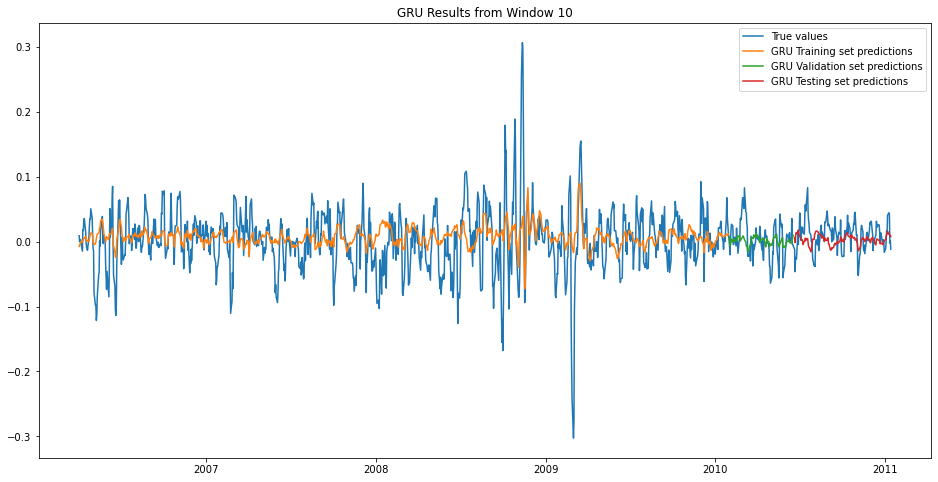

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.002384933023242436
RMSE = 0.04883577605856628
MAE = 0.03371753297032579
R-Squared = -0.025218373634008584

Results on Validation set: 
MSE = 0.0003806068047376509
RMSE = 0.019509146694247057
MAE = 0.015412797754553181
R-Squared = -0.018194389399599276

Results on Testing set: 
MSE = 0.0008971213866374369
RMSE = 0.029951984686117827
MAE = 0.023941617583883117
R-Squared = -0.37039011152337253



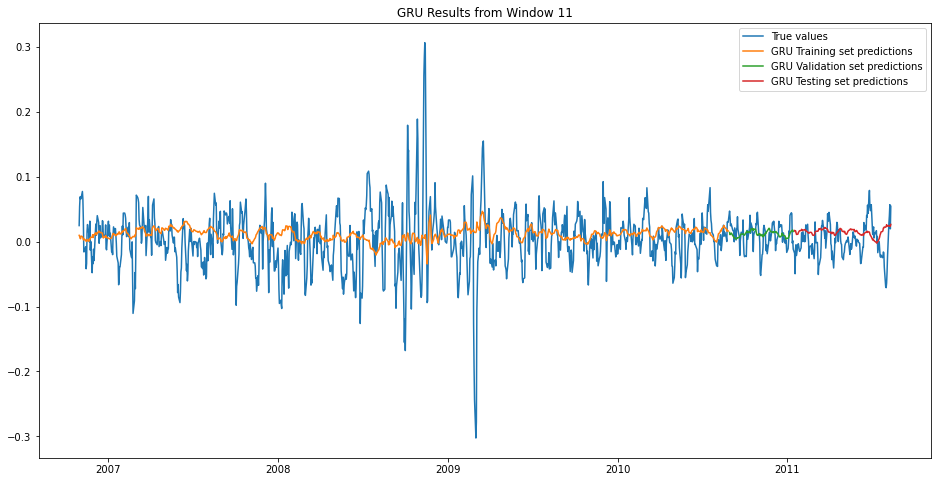

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.002230844239169927
RMSE = 0.04723181384585952
MAE = 0.03213852023484128
R-Squared = 0.002282255736635319

Results on Validation set: 
MSE = 0.0008316367655697823
RMSE = 0.028838113072283046
MAE = 0.022219747986805198
R-Squared = -0.0634475665283476

Results on Testing set: 
MSE = 0.0011362721297568938
RMSE = 0.03370863583352037
MAE = 0.027098423786490855
R-Squared = -0.9077794954540221



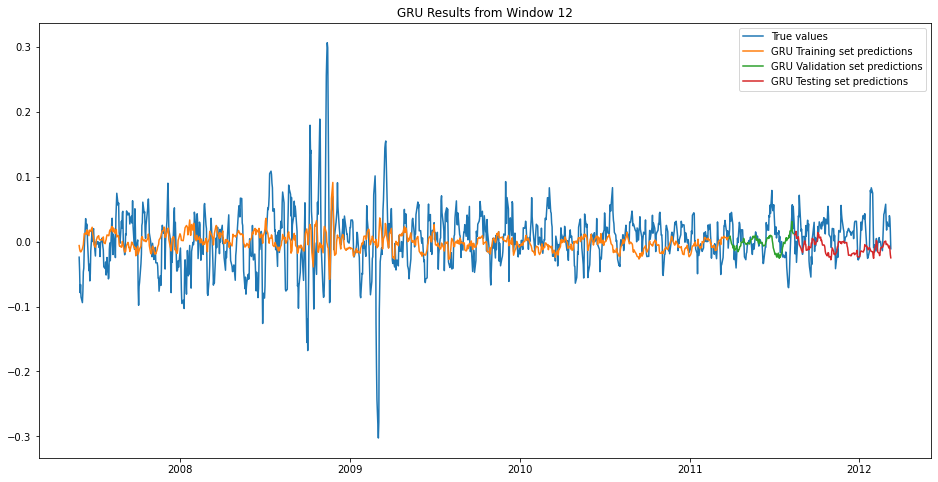

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0015454208475360331
RMSE = 0.03931184106011868
MAE = 0.02595184027359295
R-Squared = 0.26960792619033713

Results on Validation set: 
MSE = 0.0005036793455706711
RMSE = 0.022442801642635242
MAE = 0.01760930332070962
R-Squared = 0.1555966862265683

Results on Testing set: 
MSE = 0.0008713249937180034
RMSE = 0.02951821460925446
MAE = 0.02180440856166937
R-Squared = -0.008251673110742042



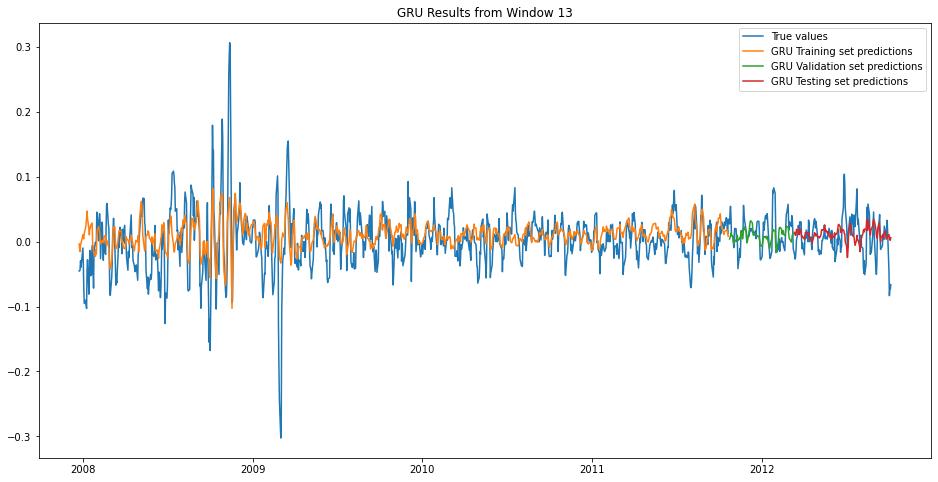

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0015087038711125674
RMSE = 0.038842037422264136
MAE = 0.02509982317041232
R-Squared = 0.18028100280760118

Results on Validation set: 
MSE = 0.001193364623502226
RMSE = 0.03454510997959372
MAE = 0.02491437800192047
R-Squared = -0.03837274391272971

Results on Testing set: 
MSE = 0.001114770344416569
RMSE = 0.033388176715965924
MAE = 0.02523309335489844
R-Squared = -0.5355423897490061



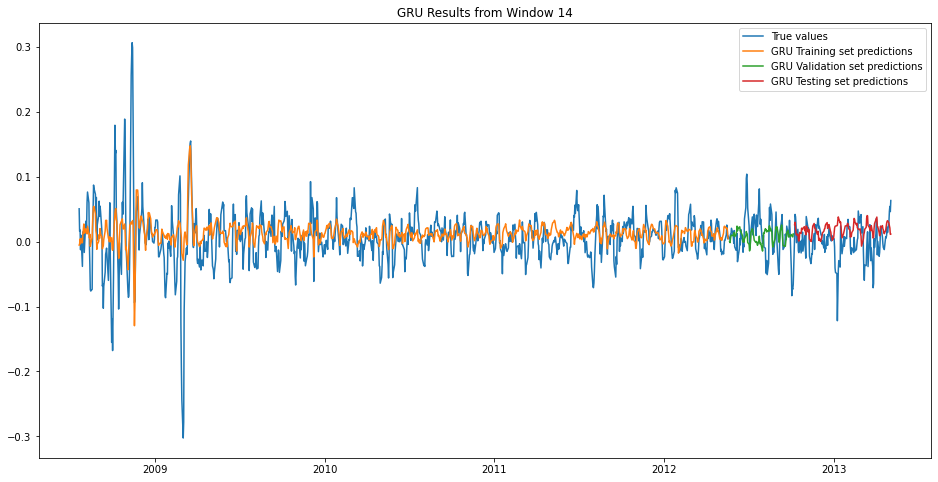

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0011579488344003015
RMSE = 0.034028647260805144
MAE = 0.023624342123740035
R-Squared = -0.02240911945617774

Results on Validation set: 
MSE = 0.00085471519811357
RMSE = 0.02923551261930548
MAE = 0.02106865137034998
R-Squared = 0.04056213663778241

Results on Testing set: 
MSE = 0.000881355239164475
RMSE = 0.02968762771196909
MAE = 0.02289793847117742
R-Squared = 0.006220855119061008



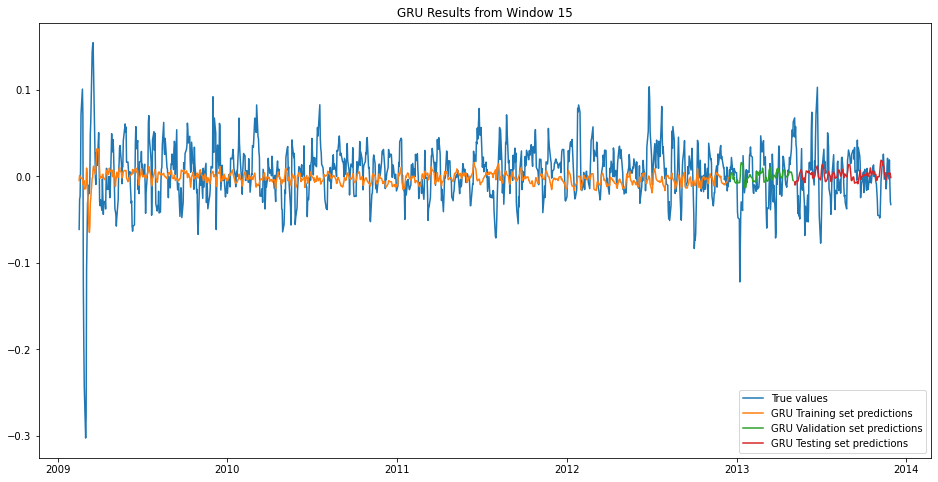

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007538850988085914
RMSE = 0.027456968128484097
MAE = 0.020833934955684242
R-Squared = 0.009364011233258251

Results on Validation set: 
MSE = 0.000532759578303367
RMSE = 0.02308158526408806
MAE = 0.017852912891924037
R-Squared = -0.12033932730772312

Results on Testing set: 
MSE = 0.0006311799191946065
RMSE = 0.025123294353937873
MAE = 0.019149696803466357
R-Squared = -0.25790551462353717



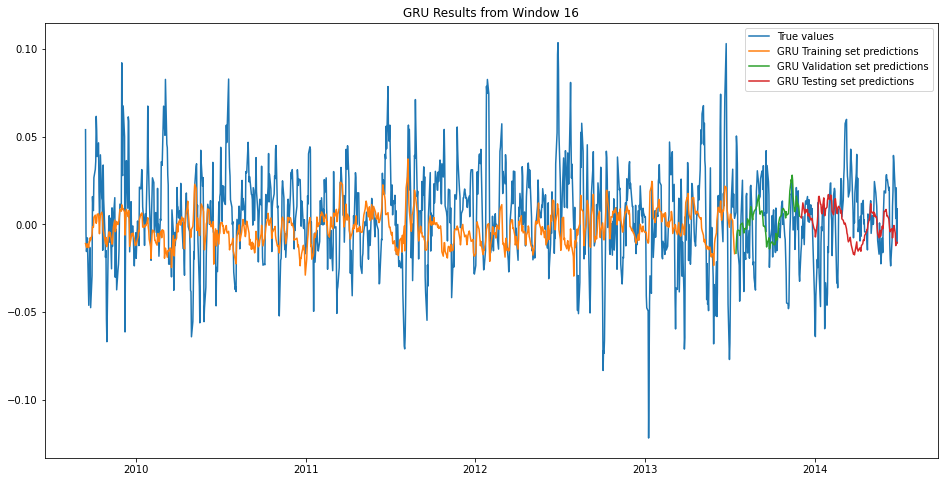

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0006390032481918894
RMSE = 0.02527851356769004
MAE = 0.01881425044786753
R-Squared = 0.12568201848777616

Results on Validation set: 
MSE = 0.0004303436099640868
RMSE = 0.020744724870773456
MAE = 0.016504413781157908
R-Squared = -0.23165437206515693

Results on Testing set: 
MSE = 0.0007448800539413771
RMSE = 0.02729249079767871
MAE = 0.021877234092438927
R-Squared = -0.035695167900156255



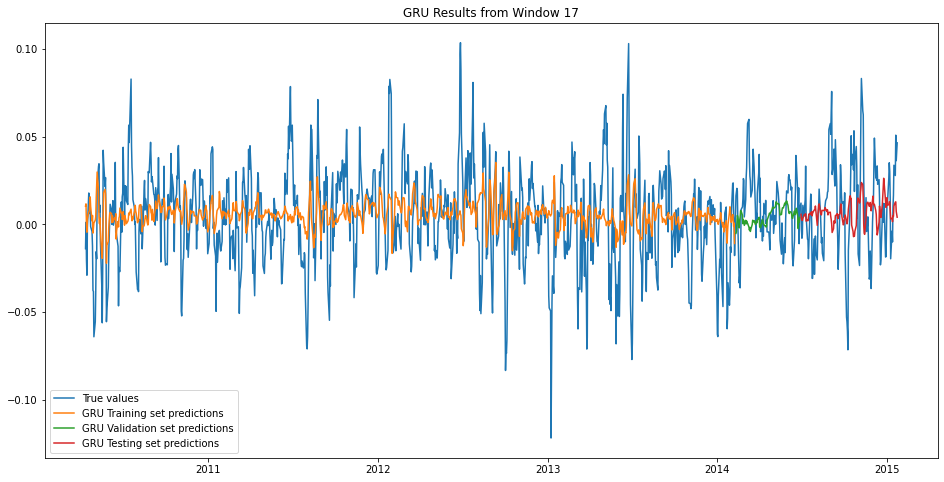

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0001871338522058783
RMSE = 0.013679687577056659
MAE = 0.009755720357800758
R-Squared = 0.7314061546931783

Results on Validation set: 
MSE = 0.0006177525805674181
RMSE = 0.024854628956542845
MAE = 0.01946422783237618
R-Squared = 0.215985422365493

Results on Testing set: 
MSE = 0.0009449224748373241
RMSE = 0.030739591325151416
MAE = 0.024875700774202415
R-Squared = -0.3537849490933491



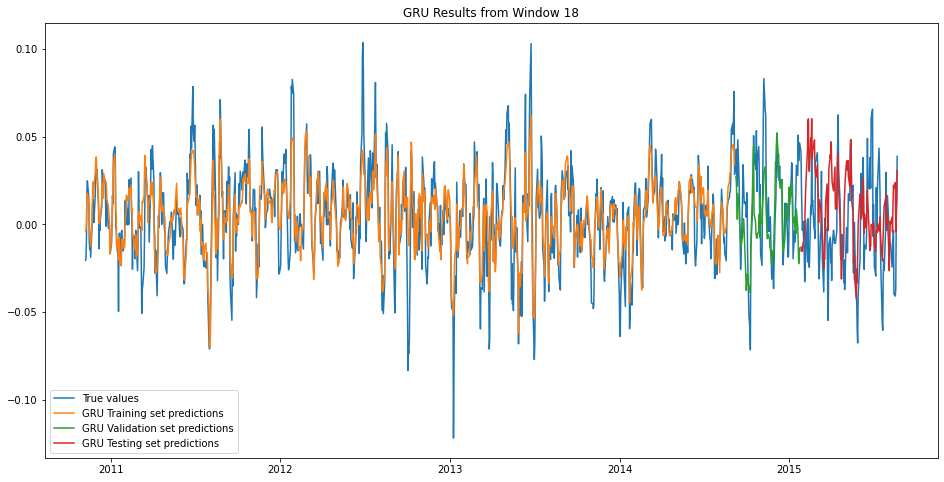

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0006747011727064054
RMSE = 0.025975010542950802
MAE = 0.01970098632863394
R-Squared = 0.10815852446180119

Results on Validation set: 
MSE = 0.0007909862601530249
RMSE = 0.028124477953430975
MAE = 0.02325030918693276
R-Squared = 0.004236884304542832

Results on Testing set: 
MSE = 0.0013108536000665998
RMSE = 0.03620571225741319
MAE = 0.030270010204379937
R-Squared = -0.15970496847117066



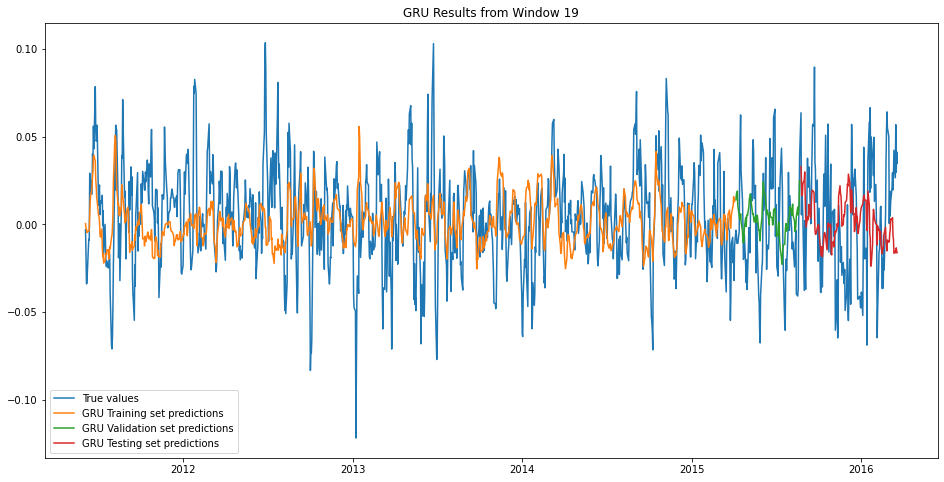

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0007573546332059162
RMSE = 0.027520076911337225
MAE = 0.0212556376560196
R-Squared = 0.01684522362140861

Results on Validation set: 
MSE = 0.0012214148789077282
RMSE = 0.03494874645688638
MAE = 0.029614652908481007
R-Squared = -0.014583520052300347

Results on Testing set: 
MSE = 0.0006441782051490265
RMSE = 0.02538066597134572
MAE = 0.020238727197616626
R-Squared = -0.0014938885841526695



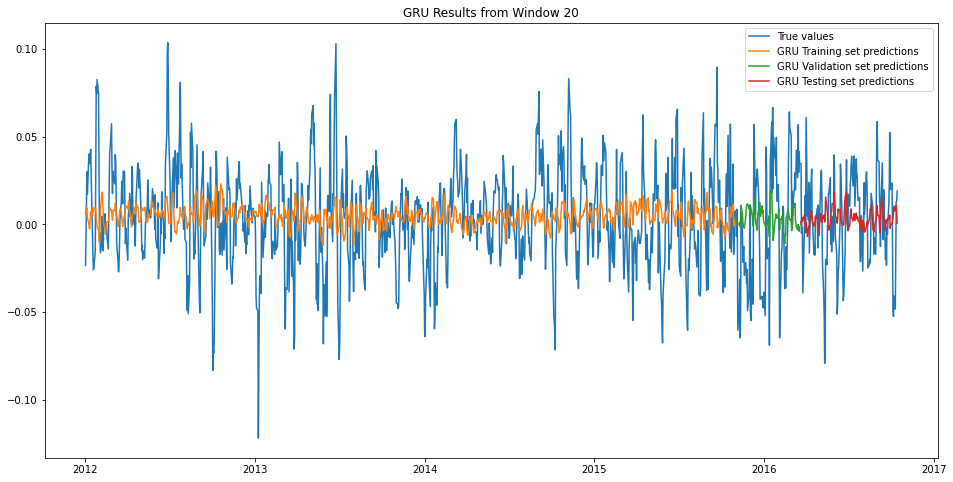

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0007238719158761572
RMSE = 0.026904867884383992
MAE = 0.02040776114798726
R-Squared = 0.1004788210455615

Results on Validation set: 
MSE = 0.0005818895993612222
RMSE = 0.024122387928254992
MAE = 0.01906418415688765
R-Squared = 0.08349663664705531

Results on Testing set: 
MSE = 0.0006943225968879829
RMSE = 0.026350001838481584
MAE = 0.02044672274801126
R-Squared = -0.28500250711988806



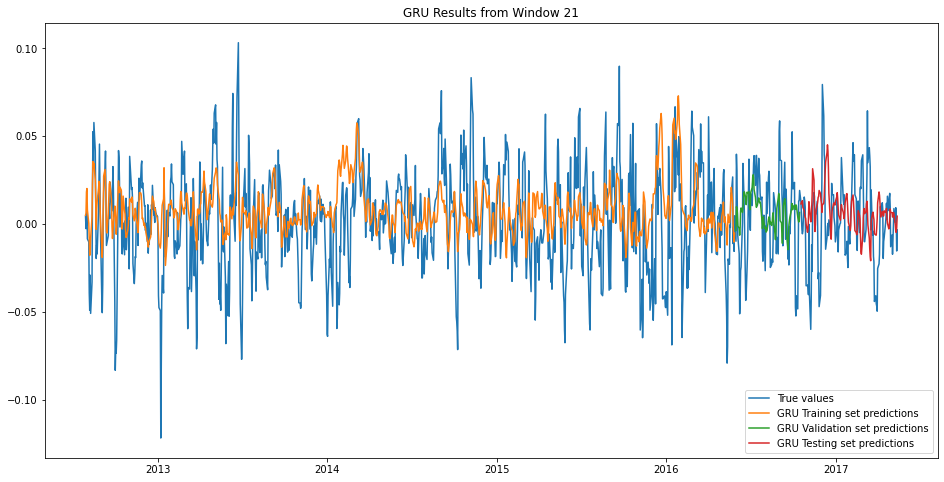

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0007605702784717382
RMSE = 0.02757843865181164
MAE = 0.021536631446740246
R-Squared = 0.02854217899199052

Results on Validation set: 
MSE = 0.0004250476537065069
RMSE = 0.02061668386784128
MAE = 0.015763267296216524
R-Squared = 0.04310287302840732

Results on Testing set: 
MSE = 0.00040884538010646797
RMSE = 0.02021992532395874
MAE = 0.015719432117442162
R-Squared = 0.04639408485936325



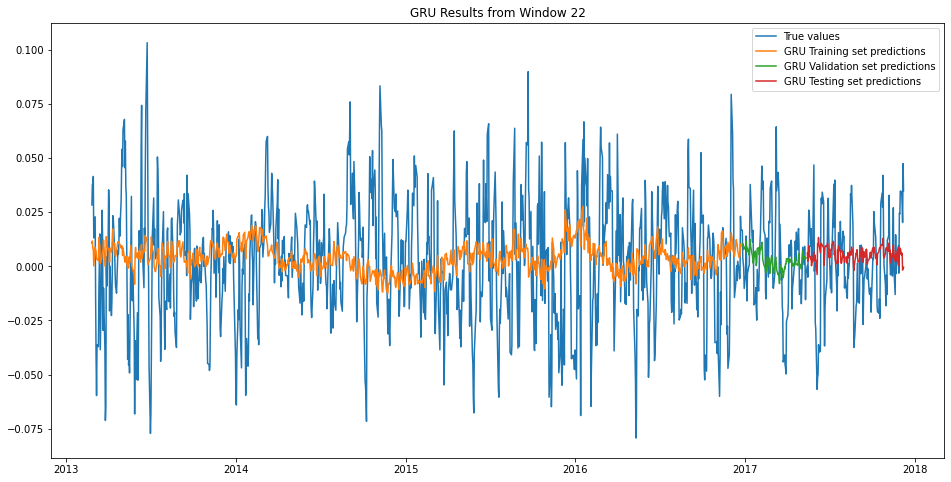

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0006657151862144731
RMSE = 0.02580145705603606
MAE = 0.019498082893789088
R-Squared = 0.0488333581865259

Results on Validation set: 
MSE = 0.00026420728792006537
RMSE = 0.016254454402411217
MAE = 0.012871693427536865
R-Squared = 0.16673653533969102

Results on Testing set: 
MSE = 0.0011860970581254575
RMSE = 0.03443975984418964
MAE = 0.026458638928444855
R-Squared = -0.03299203094245384



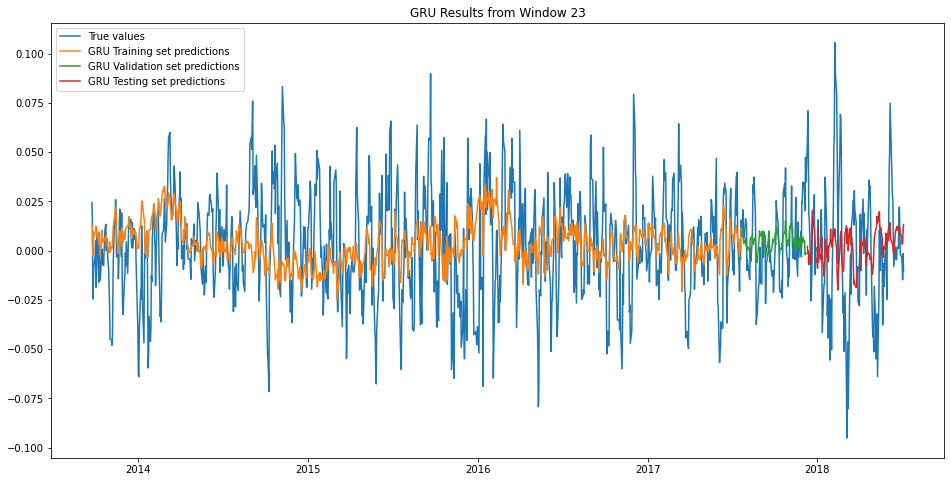

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0007244571420787924
RMSE = 0.026915741529424605
MAE = 0.02069384451109581
R-Squared = -0.011365855482360576

Results on Validation set: 
MSE = 0.0009668324304742355
RMSE = 0.031093929157863524
MAE = 0.024097111325213798
R-Squared = 0.042265447756763996

Results on Testing set: 
MSE = 0.001645256075564968
RMSE = 0.040561756317558144
MAE = 0.029881678345240387
R-Squared = -0.13380402230688837



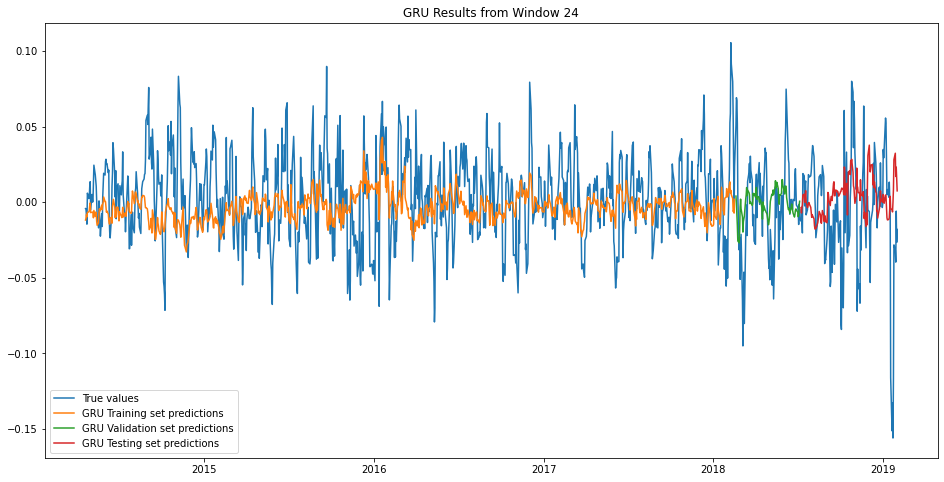

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4931

Results on Training set: 
MSE = 0.0006848860600404293
RMSE = 0.026170327855042804
MAE = 0.02037773955439485
R-Squared = 0.07990090223966795

Results on Validation set: 
MSE = 0.0019826731611271332
RMSE = 0.044527218205577736
MAE = 0.03143202172550068
R-Squared = -0.04192944046949609

Results on Testing set: 
MSE = 0.0010738529074987761
RMSE = 0.03276969495583955
MAE = 0.02576840866969172
R-Squared = -0.13339856758093505



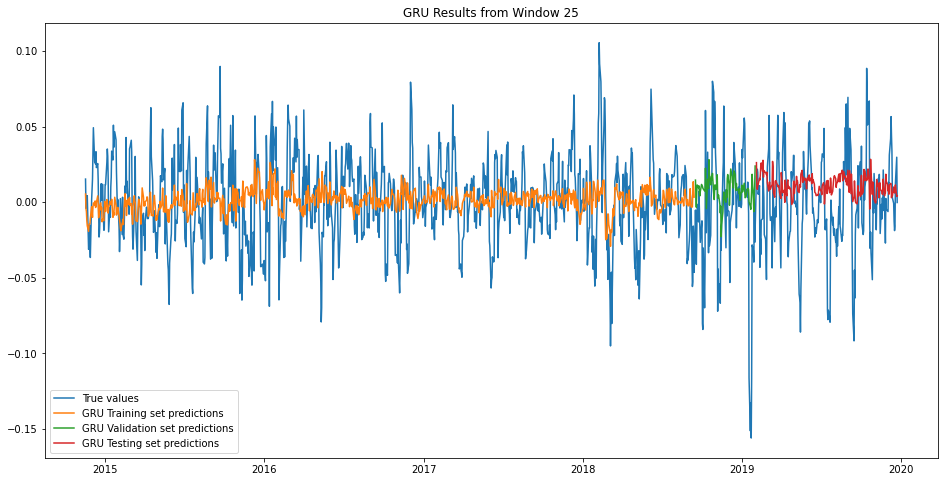

In [10]:
#Declaring model parameters
sequencelength = 187
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.001284324357707394
RMSE = 0.03583747141899654
MAE = 0.025799849892440187
R-Squared = -0.04673974773600076

GRU model results on the Testing set
MSE = 0.001347119901185206
RMSE = 0.0367031320350894
MAE = 0.02674180336879795
R-Squared = -0.09739317737531383

Naive model results on the Testing set
MSE = 0.002767383338681109
RMSE = 0.052605924938937336
MAE = 0.0377915006918443
R-Squared = -1.2638667882788766

Drift model results on the Testing set
MSE = 0.003317073140628095
RMSE = 0.057594037370443954
MAE = 0.041482333311539214
R-Squared = -1.713542288268136



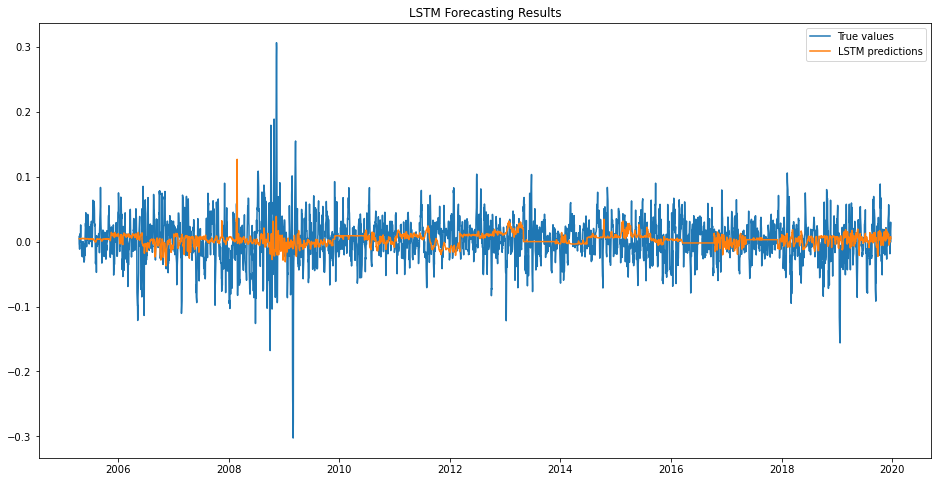

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

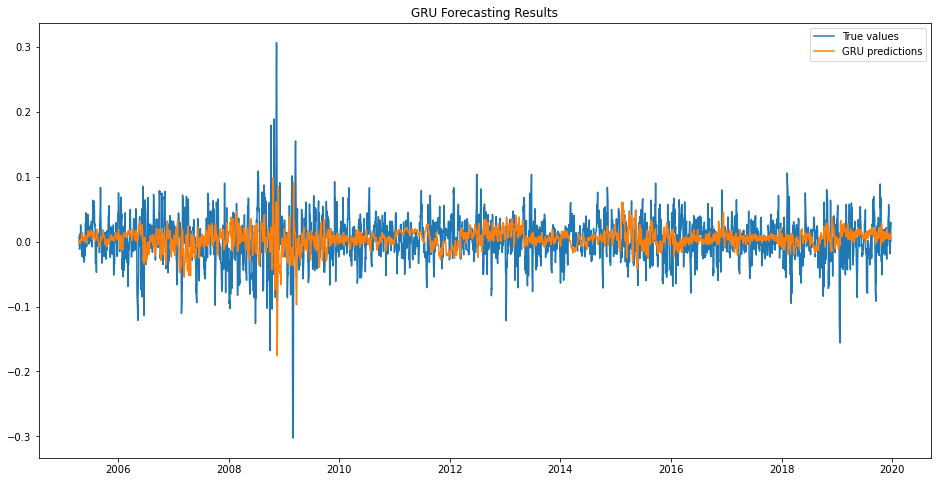

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

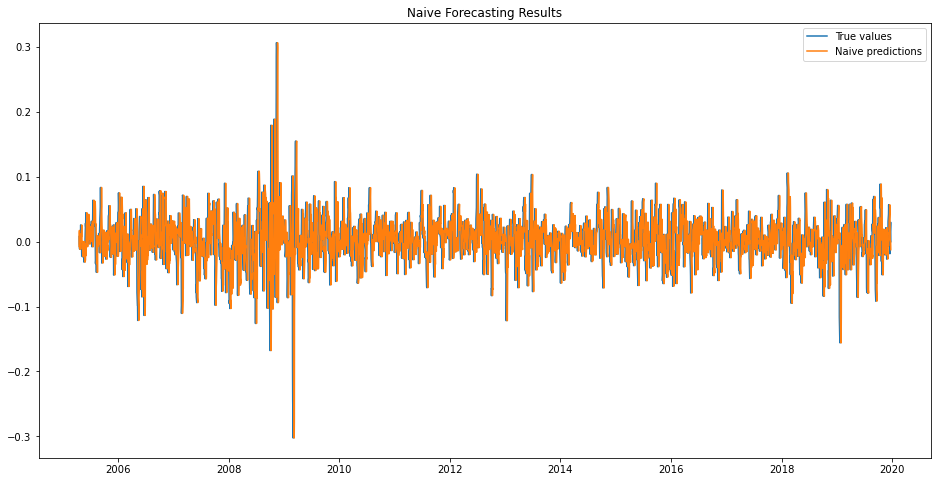

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

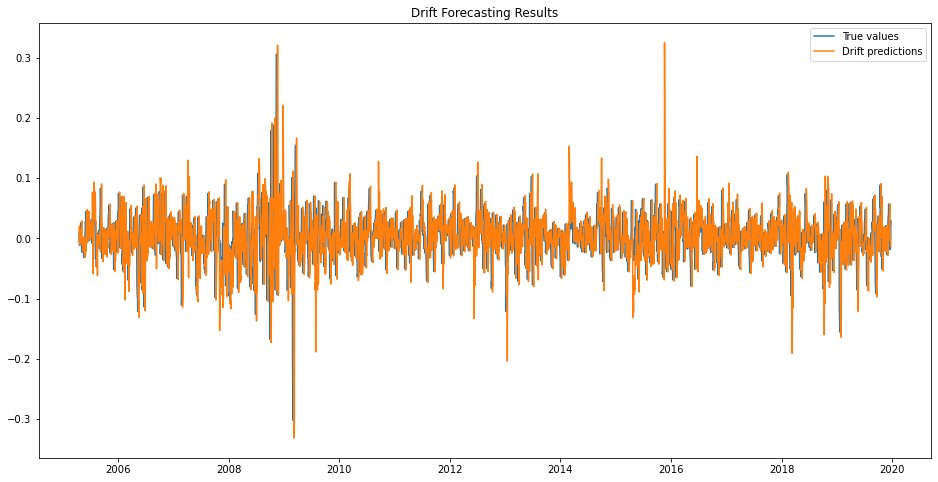

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['AVI LSTM'] = lstm_predictions[-numpreds:]
savePredictions['AVI GRU'] = gru_predictions[-numpreds:]
savePredictions['AVI Naive'] = naive_predictions[-numpreds:]
savePredictions['AVI Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./AVI_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

AVI LSTM   AVI GRU  AVI Naive  AVI Drift
Date                                                
2005-04-18  0.004344  0.001646  -0.007722  -0.005767
2005-04-19  0.004196 -0.000046   0.013214   0.016337
2005-04-20  0.004241 -0.001562   0.017108   0.020414
2005-04-21  0.004407 -0.001052   0.003884   0.006419
2005-04-22  0.004538  0.000195  -0.011606  -0.009949